In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
plt.rcParams["font.family"] = "sans-serif"
sns.set_palette("dark")
sns.set_context("talk")

%matplotlib

import numpy as np
from IPython.display import HTML, display, SVG

import pydot
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, BasicVector,
                        Parser, Saturation, Simulator, PlanarSceneGraphVisualizer, 
                        LinearQuadraticRegulator, AbstractValue, MeshcatVisualizer, 
                        StartMeshcat, WrapToSystem, SceneGraph, AbstractValue)    

from pydrake.systems.primitives import LogVectorOutput, ConstantVectorSource

from pydrake.systems.framework import LeafSystem
from pydrake.multibody import inverse_kinematics
from pydrake.multibody import plant as plnt
from pydrake.multibody import math as m
from pydrake.multibody.tree import MultibodyForces, UniformGravityFieldElement, LinearBushingRollPitchYaw

from pydrake.multibody.plant import ContactResults
from pydrake.autodiffutils import AutoDiffXd, InitializeAutoDiff, ExtractGradient
from underactuated.meshcat_cpp_utils import MeshcatSliders, MeshcatJointSliders
from Custom_LeafSystems import *

from tqdm import tqdm as tqdm

from Linearize import getGradients

from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

from pydrake.geometry import (GeometryInstance, Cylinder, MeshcatCone, SceneGraphInspector, SceneGraph_, MakePhongIllustrationProperties,
                            FramePoseVector, PerceptionProperties, GeometryFrame, Rgba)
from pydrake.math import RollPitchYaw, RotationMatrix, RigidTransform
from pydrake.common.value import Value
from pydrake.systems.framework import LeafSystem, EventStatus

# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

Using matplotlib backend: TkAgg


INFO:drake:Meshcat listening for connections at http://localhost:7002


In [2]:
builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
body = Parser(plant).AddModelFromFile("Four_Bar/four_bar_pendulum.urdf")

# Connect left and right hip via a bushing joint to form quasi closed loop robot
# Fixed joint using penalty method 3 for stiffness and method 2 for damping

# Get both bodies to connect
top = plant.GetBodyByName("top_dummy")
right = plant.GetBodyByName("right_dummy")

q_max = 0.1 * np.pi / 180  # 0.1 degrees maximum deviation
x_max = 1E-4  # 0.1 mm max deviation

M_max = 100   # Maximum estimated moment on the joint
F_max = 100   # Maximum estimated force on the joint

settling_time = 0.2 # Settling time in seconds
settling_ratio = 0.01   # Settling ratios must be either 0.01, 0.02, 0.05 or 0.10

def natural_freq(settling_ratio):
    return {"0.01": 6.64/settling_time,
            "0.02": 5.83/settling_time,
            "0.05": 4.74/settling_time,
            "0.10": 3.89/settling_time}[str(settling_ratio)]

w_n = natural_freq(settling_ratio)
zeta = 1. 

# TODO: Support numbers with mathematics
# Determine torque stiffness
k_theta = M_max / q_max * np.ones(3)

# Determine force stiffness
k_x = F_max / x_max * np.ones(3)

# Determine torque damping
d_theta = 2*zeta*k_theta / w_n

# Determine force damping
d_x = 2*zeta*k_x / w_n

# Create bushing element
bushing = plant.AddForceElement(LinearBushingRollPitchYaw(
            frameA=top.body_frame(),
            frameC=right.body_frame(),
            torque_stiffness_constants=k_theta,
            torque_damping_constants=d_theta,
            force_stiffness_constants=k_x,
            force_damping_constants=d_x))

# Finalize plant necessary for simulation
plant.Finalize()

# Visualization for the simulation
meshcat.Delete()
vis = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# Create default context and fix the input to zeros to make diagram
context = plant.CreateDefaultContext()
x0 = np.zeros(plant.num_continuous_states())
plant.SetPositionsAndVelocities(context, x0)
# CoM_0 = plant.CalcCenterOfMassPositionInWorld(context)[0:2]

plant.get_actuation_input_port().FixValue(context, np.zeros(plant.num_actuators()))

# display(SVG(pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()))

# print(dir(plant))

# generic_input = builder.AddSystem(ConstantVectorSource(np.zeros(plant.num_actuators())))

# diagram = builder.Build()
# display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

# def PoseOptimization():
#     context_diagram = diagram.CreateDefaultContext()
#     plant_context_from_diagram = diagram.GetSubsystemContext(plant, context_diagram)

#     sliders = MeshcatJointSliders(meshcat, plant, context_diagram)
#     sliders.Run(vis, context_diagram)
#     meshcat.DeleteAddedControls()
#     meshcat.Delete()

# PoseOptimization()

In [3]:
# Attemp to register a external object to geometries

def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)

# Cylinder and cone which make up the arrow
cyl = Cylinder(0.02, 0.25)
cone = MeshcatCone(0.05, 0.05, 0.05)

# Rigidbody transforms for both objects
transform = xyz_rpy_deg(np.array([0, 0, 0.25/2]), np.array([0, 0, 0]))
cone_transform = xyz_rpy_deg(np.array([0, 0, 0.15]), np.array([180, 0, 0]))

# Make cylinder and cone geometry for the arrow
# cylinder_Id = GeometryInstance(transform, cyl, "cylinder")
# cone_Id = GeometryInstance(cone_transform, cone, "cone")

# Make a red colored arrow
# color = MakePhongIllustrationProperties(np.array([1.0, 0., 0., 1.0]))
# cylinder_Id.set_illustration_properties(color)
# cone_Id.set_illustration_properties(color)

# inspector = scene_graph.model_inspector()

# body_frameId = None

# for geometry_id in inspector.GetAllGeometryIds():
#     body = plant.GetBodyFromFrameId(inspector.GetFrameId(geometry_id))
#     body_frameId = inspector.GetFrameId(geometry_id)

#     if body.name() == "top":
#         break

# print(body_frameId)

# source_id = scene_graph.RegisterSource("arrow")
# geometry_id = scene_graph.RegisterGeometry(source_id, body_frameId, cylinder_Id)
# cyl_frame = scene_graph.RegisterFrame(source_id, inspector.world_frame_id(), GeometryFrame("cyl_origin"))

# cone_vis = scene_graph.RegisterGeometry(source_id, geometry_id, cone_Id)
# # geometry_cone = scene_graph.RegisterGeometry(source_id, cyl_frame, cone_Id)

# print(dir(inspector))


In [4]:
# top_WF = plant.EvalBodyPoseInWorld(context, plant.GetBodyByName("top"))

# print(dir(meshcat))
# red = Rgba(1.0, 0, 0, 1.0)

# meshcat.SetObject("arrow/cyl", cyl, red)
# meshcat.SetObject("arrow/cone", cone, red)

# meshcat.SetTransform("arrow/cyl", transform)
# meshcat.SetTransform("arrow/cyl", cone_transform)

# meshcat.SetTransform("arrow", top_WF)



In [5]:
from multiprocessing import Event
from os import stat_result


nr_states = plant.num_continuous_states()

class modifyArrow(LeafSystem):
    def __init__(self, plant, link_name, Force, meter_per_newton):
        LeafSystem.__init__(self)
        
        self.plant = plant
        self.plant_context = plant.CreateDefaultContext()
        self.link_name = link_name
        len_arrow = Force * meter_per_newton
        width_arrow = len_arrow / 10.

        cyl = Cylinder(width_arrow, len_arrow)
        cone = MeshcatCone(2*width_arrow, 2*width_arrow, 2*width_arrow)
        red = Rgba(1.0, 0, 0, 1.0)

        OutOfFrame = self.xyz_rpy_deg(np.array([0, 0, -1]), np.zeros(3))
        cyl_transform = xyz_rpy_deg(np.array([0, 0, len_arrow/2]), np.array([0, 0, 0]))
        cone_transform = xyz_rpy_deg(np.array([0, 0, len_arrow + width_arrow]), np.array([180, 0, 0]))

        meshcat.SetObject("arrow/cyl", cyl, red)
        meshcat.SetObject("arrow/cone", cone, red)

        meshcat.SetTransform("arrow/cyl", cyl_transform)
        meshcat.SetTransform("arrow/cone", cone_transform)

        meshcat.SetTransform("arrow", OutOfFrame)

        self.input = self.DeclareVectorInputPort("vec_in", BasicVector(nr_states))
        self.output = self.DeclareVectorOutputPort("update", BasicVector(1), self.CalcTransform)
        self.DeclarePeriodicPublish(1/500, 0.0)

    def CalcTransform(self, context, pose):
        states = self.input.Eval(context)
        self.plant.SetPositionsAndVelocities(self.plant_context, states)
        link_WF = plant.EvalBodyPoseInWorld(self.plant_context, self.plant.GetBodyByName(self.link_name))

        if 0.02 < context.get_time() < 0.15:
            meshcat.SetTransform("arrow", link_WF)

        pose.SetFromVector([1])

    def xyz_rpy_deg(self, xyz, rpy_deg):
        """Shorthand for defining a pose."""
        rpy_deg = np.asarray(rpy_deg)
        return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)
        

class test_class(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        self.input = self.DeclareVectorInputPort("vec_in", BasicVector(1))
        self.output = self.DeclareVectorOutputPort("vec_out", BasicVector(1), self.CalcUpdate)

    def CalcUpdate(self, context, output):
        x = self.input.Eval(context)
        output.SetFromVector(np.array([0]))

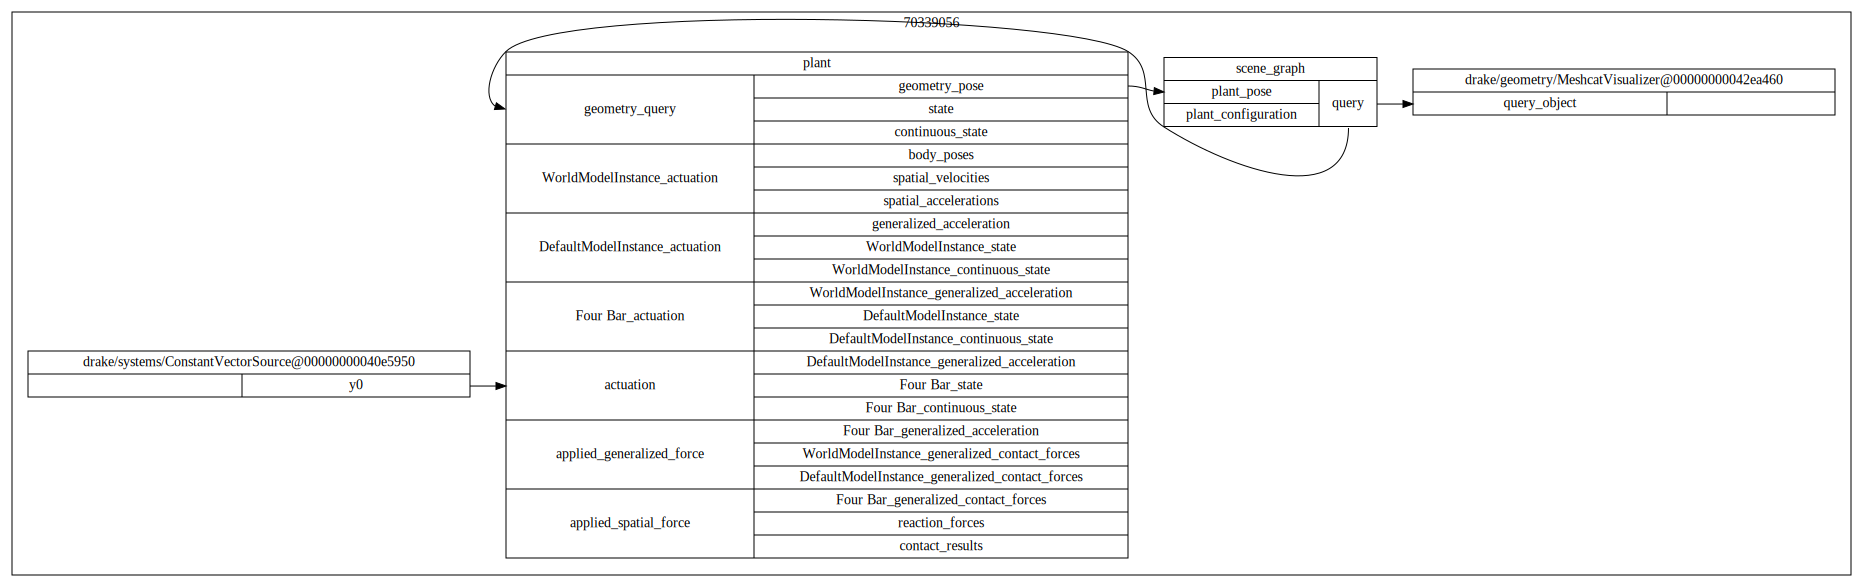

In [6]:
# generic_input = builder.AddSystem(ConstantVectorSource(100*np.ones(plant.num_actuators())))
# builder.Connect(generic_input.get_output_port(), plant.get_actuation_input_port())

# def getTorquesHoppingLeg(position, torque):
#     path = "Four_Bar/four_bar_pendulum.urdf"
#     eq_state = np.hstack((position, np.zeros(plant.num_velocities())))
#     eq_input = torque
#     sys_autodiff = getGradients(eq_state, eq_input, path)
#     sys_autodiff.makePlantFromURDF()
#     sys_autodiff.getGradients()

#     Q = np.eye(plant.num_positions() + plant.num_velocities())

#     R = np.eye(plant.num_actuators())

#     K, S = LinearQuadraticRegulator(sys_autodiff.A, sys_autodiff.B, Q, R)
#     return K, sys_autodiff.A, sys_autodiff.B

# x0 = np.zeros(plant.num_positions())
# tau = np.zeros(plant.num_actuators())

# lqr_gain, A, B = getTorquesHoppingLeg(x0, tau)



# print(A, B, lqr_gain)

# Add systems to diagram
# LQR_sys = builder.AddSystem(LQR_system(plant, plant.num_continuous_states(), plant.num_actuators(), lqr_gain))
des_state = builder.AddSystem(ConstantVectorSource(np.zeros(plant.num_actuators())))
builder.Connect(des_state.get_output_port(), plant.get_actuation_input_port())

# builder.Connect(plant.get_state_output_port(), LQR_sys.get_input_port(0))
# builder.Connect(des_state.get_output_port(), LQR_sys.get_input_port(1))
# builder.Connect(LQR_sys.get_output_port(), plant.get_actuation_input_port())

# pose_system = builder.AddSystem(modifyArrow(plant, "top", 100., 1/1000.))
# dummy_in = builder.AddSystem(test_class())

# builder.Connect(pose_system.get_output_port(), dummy_in.get_input_port())
# builder.Connect(dummy_in.get_output_port(), plant.get_actuation_input_port())
# builder.Connect(plant.get_state_output_port(), pose_system.get_input_port())

diagram = builder.Build()
display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

In [7]:
# Simulator

simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()

sim_context.SetTime(0.)

q0 = np.array([0.01, 0, 0, 0])
x0 = np.hstack((q0, np.zeros(plant.num_velocities())))

sim_context.SetContinuousState(x0)

# Record the simulation of 2 seconds
vis.StartRecording()
simulator.set_publish_every_time_step(True)
simulator.AdvanceTo(2)
vis.StopRecording()
vis.PublishRecording()

meshcat.DeleteAddedControls()